In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px 
import pandas as pd

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)
me_hca

# Define unknown constants
#g_ag = 2e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
#lmda = (g_ag/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value #Crystal volume, in AA^3
mass = 5*unit.t
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper

s_in_y = 365.25*24*60*60 #Number of seconds in a year

In [3]:
s_in_y

31557600.0

In [4]:
def complete_dndt(max_hkl = 5, print_output = False, all_even = False, k=[1,0,0], abs_forgot = True, coupling=2e-10, time=3):
    if not all_even:
        hkl = np.array(make_hkl_s(max_h = max_hkl, 
                                max_k = max_hkl,
                                max_l = max_hkl))
    else:
        hkl = np.array(make_hkl(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl, s=True))
        
    g_ag = coupling

    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq = FA_q(mod2_g)

    ginv_array = 1/mod2_g

    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

    ghat = g_arr*np.sqrt(ginv_replicant)

    if abs_forgot:
        gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k))))
    else:
        gk = gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))

    sin2 = 4*gk**2*(1-gk**2) #Only dependence on k

    summand = FAq*ginv_array*sin2*4 #Use *4 if implementing s

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV #I lied this depends on k as well
    #The infinities here are fine; they go to zero in the W function

    W = w_func(E_arr, E1=1, E2=10, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
     
    #W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report
    dphi_de = make_dpde(E_arr, coupling=g_ag)
    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    #Conversion factor of angstroms to cm missing somewhere
    #Absorption also looks like it's a huge deal (order -9 or so)
    final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
    if print_output:
        print("dN/dt = {:.3e} s^(-1)".format(final_dndt))
    return (final_dndt*(unit.s**(-1))*(time*unit.year)).si

def theta_funcd(theta_func, phi, g_ag=2e-10):
    output = []
    for p in phi:
        k_vec = k_from_polar(theta_func(p), p)
        output.append(complete_dndt(abs_forgot = True, all_even=False, coupling = g_ag, k=k_vec))
    return np.array(output)

def line_integral(theta_func, phi, g_ag=2e-10, t=3):
    dphi = np.diff(phi)
    integral = 0
    for index in range(len(phi)-1):
        p = phi[index]
        k_vec = k_from_polar(theta_func(p), p)
        integral += complete_dndt(abs_forgot = True, all_even=False, coupling = g_ag, k=k_vec, time=t)*dphi[index]
    return integral


In [5]:
phi_axis =  np.arange(0, 2*np.pi, 0.05)
theta_axis = np.arange(0,np.pi, 0.05)
angle_plane = np.array(list(itertools.product(phi_axis, theta_axis)))

def angle_dependence(g_ag = 2e-10, t=3):
    outputs = []
    for angles in angle_plane:
        phi = angles[0]
        theta = angles[1]
        k_vec = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        outputs.append(complete_dndt(k = k_vec, abs_forgot = True, all_even=False, coupling = g_ag, time=t))
    return np.array(outputs)

rates_on_angle = angle_dependence(g_ag = 5.5e-11, t=10)
rates_square = np.reshape(rates_on_angle, (len(phi_axis), len(theta_axis)))

C:\Users\taase\AppData\Local\Temp\ipykernel_11472\3082744402.py:33: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV #I lied this depends on k as well
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:104: RuntimeWarning: overflow encountered in exp
  dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))


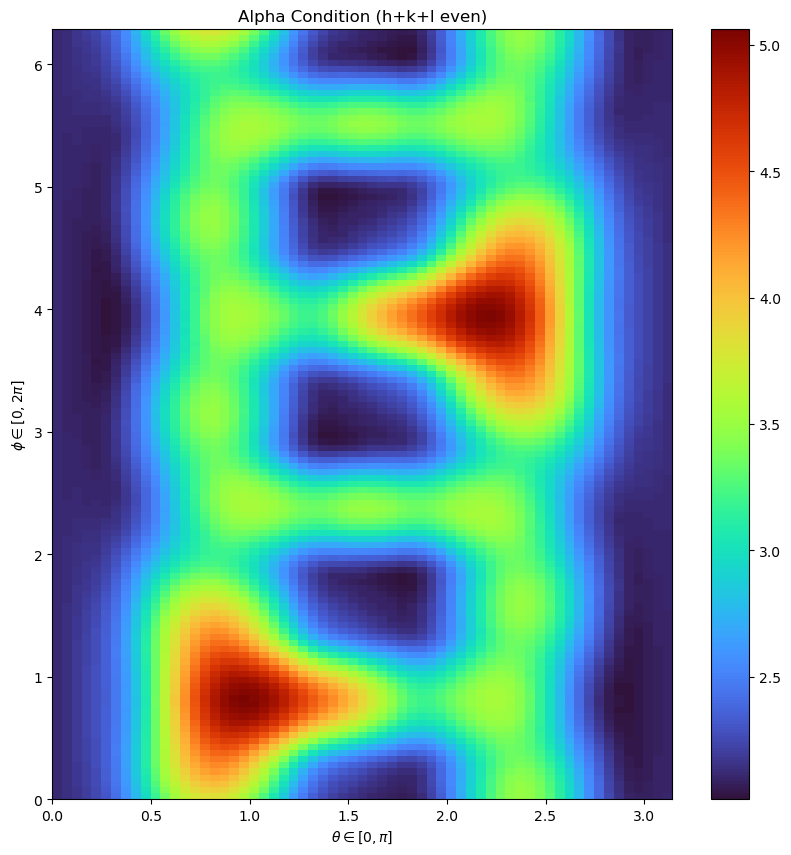

In [6]:
#theta_phi = lambda x: (np.pi/2)-0.99*np.cos(x)+0.44
theta_phi = lambda x: (np.pi/2)-54.06476699*np.pi/180*np.cos(x)-35.22555939*np.pi/180

fig,ax = plt.subplots(figsize=(10,10))
image = ax.imshow(rates_square, interpolation='none', extent = (0,np.pi,0,2*np.pi), aspect='auto', origin='lower', cmap='turbo')
#path = ax.plot(theta_phi(phi_axis), phi_axis, c="white")
#ax.scatter(alt_polar, az_rad, c="magenta")
plt.colorbar(image)
plt.title("Alpha Condition (h+k+l even)")
plt.xlabel("$\\theta \in [0,\pi]$")
plt.ylabel("$\phi \in [0,2\pi]$")
plt.show()

In [7]:
cosine_fits = pd.read_csv("..\\cosine_fits.csv", index_col=0)
cosine_fits

,Date,a,p,v
0,2024-01-01,0.943608,0.001568,0.614802
1,2024-01-02,0.943340,0.001402,0.612553
2,2024-01-03,0.943016,0.001268,0.610089
3,2024-01-04,0.942709,0.001111,0.607428
4,2024-01-05,0.942398,0.000971,0.604559
...,...,...,...,...
361,2024-12-27,0.950292,0.000216,0.619710
362,2024-12-28,0.950145,0.000022,0.618368
363,2024-12-29,0.944193,0.001921,0.619068
364,2024-12-30,0.943916,0.001775,0.617309


In [8]:
def cosine_func(x, amp, phase, vert):
    return amp*np.cos((x-np.pi/180*phase))+vert

In [9]:
fits = np.array(cosine_fits[["a","p","v"]])
fits

array([[0.94360819, 0.00156806, 0.61480199],
       [0.94333975, 0.00140209, 0.61255301],
       [0.94301566, 0.00126777, 0.61008875],
       ...,
       [0.94419345, 0.00192126, 0.61906764],
       [0.9439158 , 0.00177472, 0.61730912],
       [0.94367286, 0.00161601, 0.61532635]])

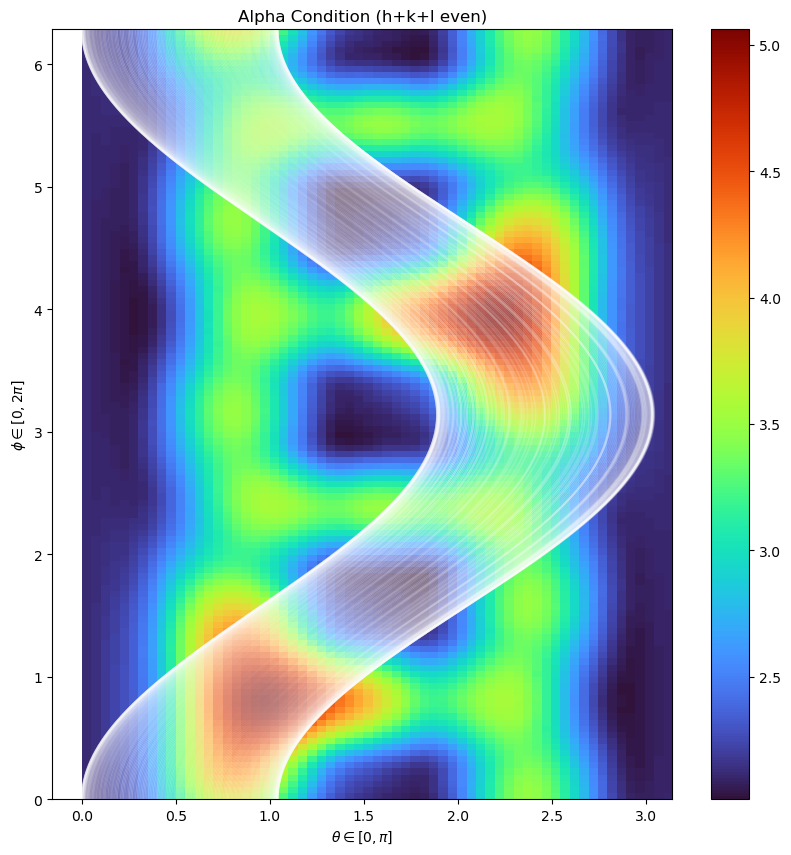

In [42]:
fig,ax = plt.subplots(figsize=(10,10))
image = ax.imshow(rates_square, interpolation='none', extent = (0,np.pi,0,2*np.pi), aspect='auto', origin='lower', cmap='turbo')
#path = ax.plot(theta_phi(phi_axis), phi_axis, c="white")
#ax.scatter(alt_polar, az_rad, c="magenta")

phi_axis = np.arange(0, 2*np.pi, 0.01)
for triplet in fits:
    ax.plot(np.pi/2-cosine_func(phi_axis, *triplet), phi_axis, c="white", alpha=0.15)

plt.colorbar(image)
plt.title("Alpha Condition (h+k+l even)")
plt.xlabel("$\\theta \in [0,\pi]$")
plt.ylabel("$\phi \in [0,2\pi]$")
plt.show()

In [12]:
def annual_change(coupling = 5.5e-11, time=10):
    output = []
    phi_axis = np.arange(0, 2*np.pi, 0.01)
    for triplet in fits:
        theta_phi = lambda x: cosine_func(x, *triplet)
        output.append(line_integral(theta_phi, phi_axis, g_ag = coupling, t=time))
    return np.array(output)

In [13]:
lines_annual = annual_change() #RUN THIS LIKE IMMEDIATELY TOMORROW AND SAVE THE OUTPUT
#It's like 2s*number of fits okay (give it 15 mins probably)

C:\Users\taase\AppData\Local\Temp\ipykernel_11472\3082744402.py:33: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV #I lied this depends on k as well
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:104: RuntimeWarning: overflow encountered in exp
  dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))


In [47]:
cosine_fits["Alpha Counts"] = lines_annual/(2*np.pi)

In [56]:
cosine_fits

,Date,a,p,v,Alpha Counts
0,2024-01-01,0.943608,0.001568,0.614802,2.825875
1,2024-01-02,0.943340,0.001402,0.612553,2.826936
2,2024-01-03,0.943016,0.001268,0.610089,2.828098
3,2024-01-04,0.942709,0.001111,0.607428,2.829363
4,2024-01-05,0.942398,0.000971,0.604559,2.830740
...,...,...,...,...,...
361,2024-12-27,0.950292,0.000216,0.619710,2.823827
362,2024-12-28,0.950145,0.000022,0.618368,2.824485
363,2024-12-29,0.944193,0.001921,0.619068,2.823868
364,2024-12-30,0.943916,0.001775,0.617309,2.824694


In [57]:
cosine_fits.to_csv("..\\cosine_fits.csv")

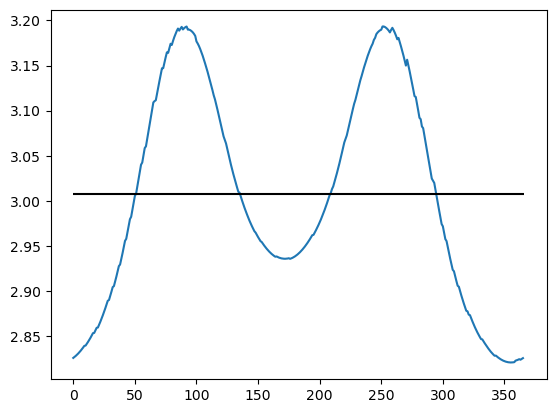

In [55]:
fig, ax = plt.subplots()
ax.plot(range(0,366), lines_annual/(2*np.pi))
ax.hlines(3.007534546581472, 0, 366, color="black")

In [50]:
np.trapz(lines_annual/(2*np.pi), np.linspace(0, 366, len(lines_annual)))/(366)

3.007534546581472

In [51]:
np.argmin(np.abs(3.007534546581472 - lines_annual/(2*np.pi)))

51

In [53]:
lines_annual[51]/(2*np.pi) - 3.007534546581472

0.000460274514393344

In [54]:
cosine_fits["Date"][51]

'2024-02-21'